# EDA using Scatterplots
This notebook explores the GDP and CO2 emissions datasets contained in `..\data\final`.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
pd.set_option('display.max_columns', 100)

In [ ]:
df = pd.read_csv('../data/final/gdp_co2_emissions.csv')
df_top40 = pd.read_csv('../data/final/gdp_co2_emissions_top40_2024.csv')

 ---

Quick inspection

In [ ]:
df.head()

,Country Name,Country Code,Continent,Year,Total CO2 emissions,CO2 emissions per capita,GDP,GDP per capita,GDP growth (annual %)
0,Afghanistan,AFG,Asia,2000,1047127.94,0.052017,6.206548e+09,1617.826475,NaN
1,Afghanistan,AFG,Asia,2001,1069098.00,0.052706,5.621148e+09,1454.110782,-9.431974
2,Afghanistan,AFG,Asia,2002,1341065.00,0.062731,7.228796e+09,1774.308743,28.600001
3,Afghanistan,AFG,Asia,2003,1559679.00,0.068608,7.867263e+09,1815.928200,8.832278
4,Afghanistan,AFG,Asia,2004,1237247.00,0.052513,7.978516e+09,1776.918207,1.414118


In [ ]:
df_top40.head()

,Country Name,Country Code,Continent,Year,Total CO2 emissions,CO2 emissions per capita,GDP,GDP per capita,GDP growth (annual %)
0,United States,USA,North America,2024,4.904120e+09,14.197287,2.256846e+13,75489.266433,2.793001
1,China,CHN,Asia,2024,1.228904e+10,8.658390,1.848811e+13,23845.619722,4.977357
2,Japan,JPN,Asia,2024,9.618673e+08,7.772474,4.606003e+12,46106.922923,0.104309
3,Germany,DEU,Europe,2024,5.723192e+08,6.768824,3.677049e+12,62554.554723,-0.495852
4,India,IND,Asia,2024,3.193478e+09,2.200978,3.477821e+12,9818.042707,6.494766


 ---
## Scatter Plots
**Scatter plots** (standard scale) between GDP per capita and CO2 emissions per capita to understand if there is linear correlation.

The [Environmental Kuznets Curve (EKC)](https://en.wikipedia.org/wiki/Kuznets_curve) theory suggests that a developing country initially produce high emissions, they reach a peak, but then decline as the economy becomes more efficient. In a standard scatter plot this results in an inverted _U-shape_.

### 1. Scatter Plots across all countries (1960-2024)

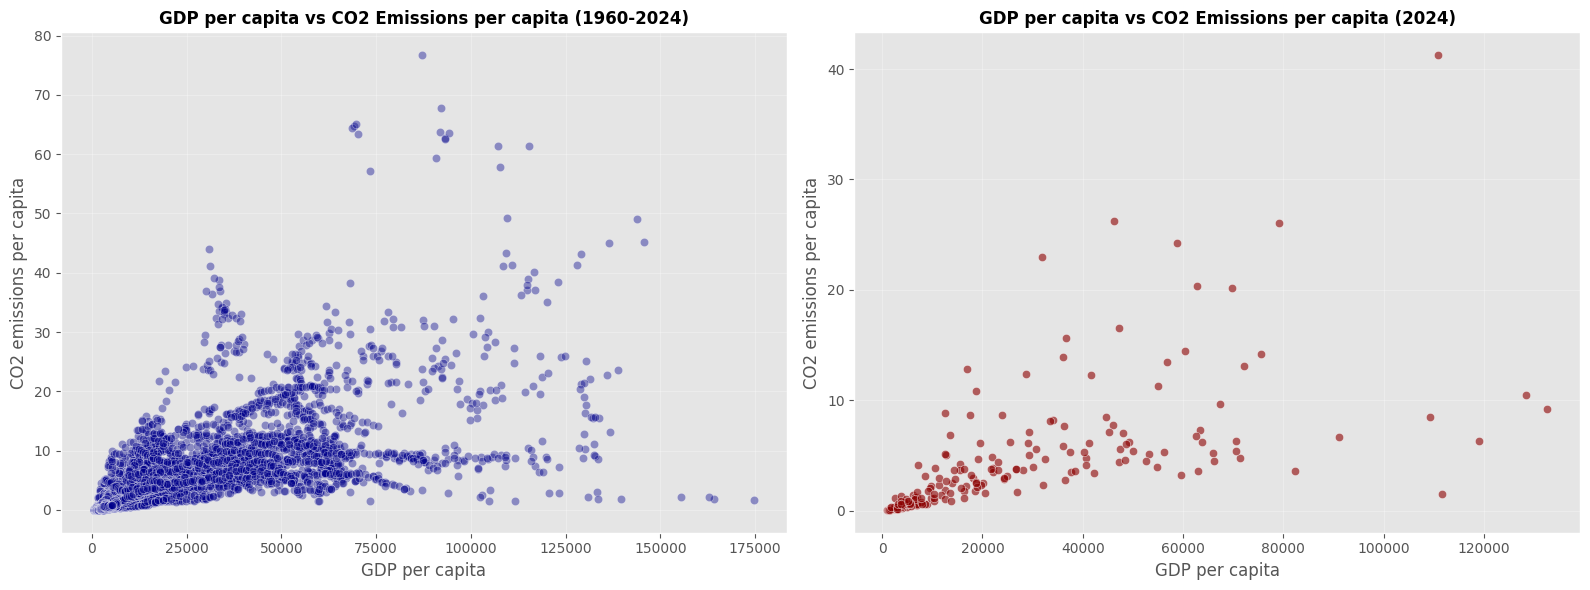

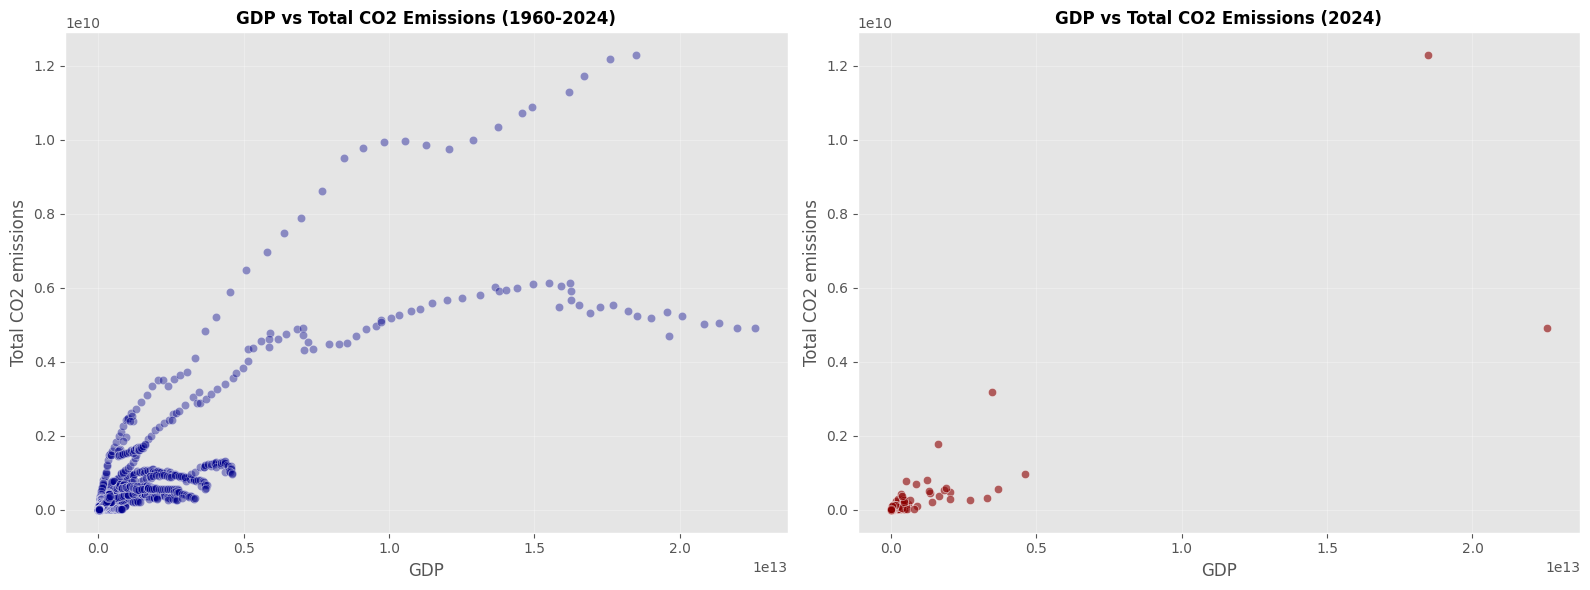

In [ ]:
# Filter out outliers
df_filtered = df[df['CO2 emissions per capita'] < 350].copy()
df_2024 = df_filtered[df_filtered['Year'] == 2024]

min_year = df_filtered['Year'].min()
max_year = df_filtered['Year'].max()

# Plot 1: GDP per capita vs CO2 emissions per capita
fig1, axes1 = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1a: All years - per capita
sns.scatterplot(data=df_filtered, x='GDP per capita', 
                y='CO2 emissions per capita', alpha=0.4, color='darkblue', ax=axes1[0])
axes1[0].set_title(f'GDP per capita vs CO2 Emissions per capita ({min_year}-{max_year})', fontsize=12, fontweight='bold')
axes1[0].set_xlabel('GDP per capita')
axes1[0].set_ylabel('CO2 emissions per capita')
axes1[0].grid(True, alpha=0.3)

# Subplot 1b: Year 2024 - per capita
sns.scatterplot(data=df_2024, x='GDP per capita', 
                y='CO2 emissions per capita', alpha=0.6, color='darkred', ax=axes1[1])
axes1[1].set_title('GDP per capita vs CO2 Emissions per capita (2024)', fontsize=12, fontweight='bold')
axes1[1].set_xlabel('GDP per capita')
axes1[1].set_ylabel('CO2 emissions per capita')
axes1[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/plots/scatterplots/scatterplot_gdp_vs_co2_per_capita.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: GDP vs Total CO2 emissions
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 2a: All years - total
sns.scatterplot(data=df_filtered, x='GDP', 
                y='Total CO2 emissions', alpha=0.4, color='darkblue', ax=axes2[0])
axes2[0].set_title(f'GDP vs Total CO2 Emissions ({min_year}-{max_year})', fontsize=12, fontweight='bold')
axes2[0].set_xlabel('GDP')
axes2[0].set_ylabel('Total CO2 emissions')
axes2[0].grid(True, alpha=0.3)

# Subplot 2b: Year 2024 - total
sns.scatterplot(data=df_2024, x='GDP', 
                y='Total CO2 emissions', alpha=0.6, color='darkred', ax=axes2[1])
axes2[1].set_title('GDP vs Total CO2 Emissions (2024)', fontsize=12, fontweight='bold')
axes2[1].set_xlabel('GDP')
axes2[1].set_ylabel('Total CO2 emissions')
axes2[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/plots/scatterplots/scatterplot_gdp_vs_total_co2.png', dpi=300, bbox_inches='tight')
plt.show()

The majority of data is concentrated in the bottom-left angle of the plot (low income, low emissions), although few countries with medium GDP per capita produce high CO2 emissions. 

According to EKC theory, we should see the upside-down _U-shape_ in the plot above, however, the data distribution only flattens and stabilize as the wealth grows. This doesn't actually confirm the EKC supposition of a net decline, nor shows a strong linear correlation between GDP and CO2 emissions.

Nonetheless, transforming the data into logarithmic scale could possibly help, as can be seen in the next cells.

 --- 
### 2. Scatter plots Top-40 countries (2024)

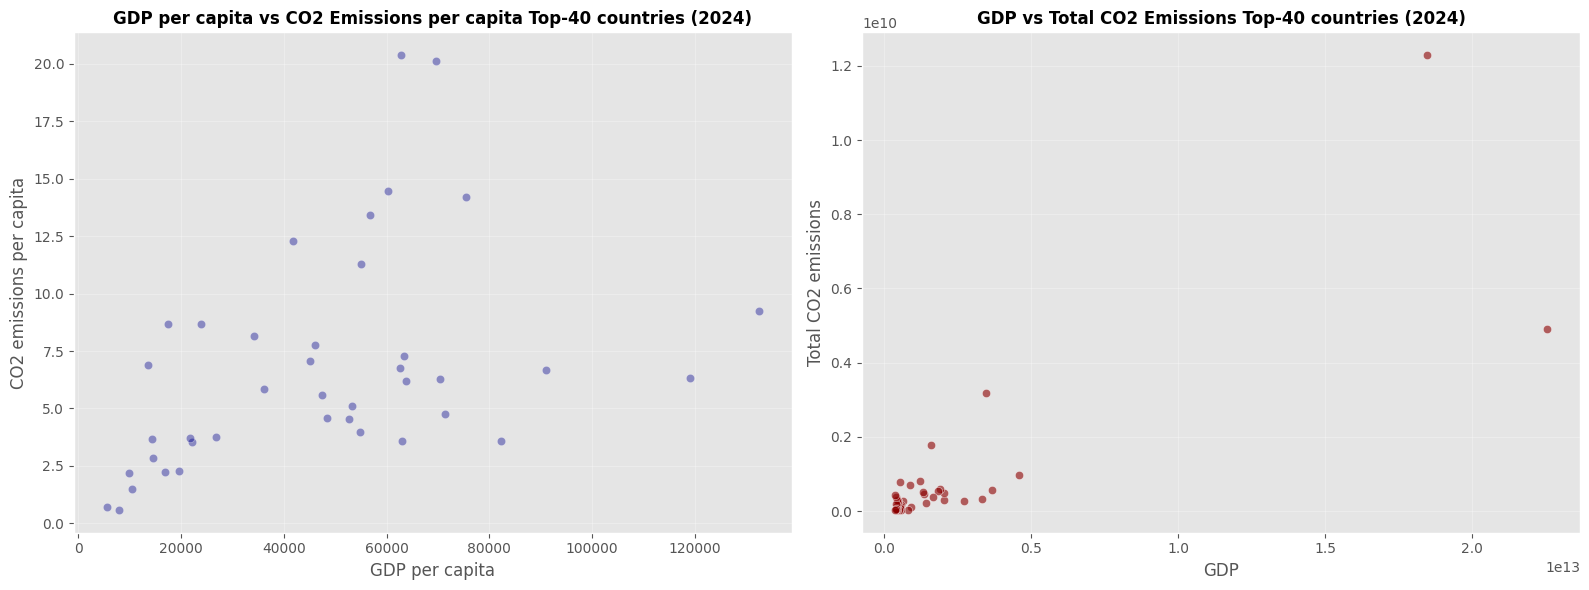

In [ ]:
# GDP per capita vs CO2 emissions per capita
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot a: Year 2024 - per capita
sns.scatterplot(data=df_top40, x='GDP per capita', 
                y='CO2 emissions per capita', alpha=0.4, color='darkblue', ax=axes[0])
axes[0].set_title(f'GDP per capita vs CO2 Emissions per capita Top-40 countries (2024)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('GDP per capita')
axes[0].set_ylabel('CO2 emissions per capita')
axes[0].grid(True, alpha=0.3)

# Subplot b: Year 2024 - total
sns.scatterplot(data=df_top40[df_top40['Year'] == 2024], x='GDP', 
                y='Total CO2 emissions', alpha=0.6, color='darkred', ax=axes[1])
axes[1].set_title('GDP vs Total CO2 Emissions Top-40 countries (2024)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('GDP')
axes[1].set_ylabel('Total CO2 emissions')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/plots/scatterplots/scatterplot_gdp_vs_co2_top_40.png', dpi=300, bbox_inches='tight')
plt.show()

 ---
### 3. Scatterplots across all continents

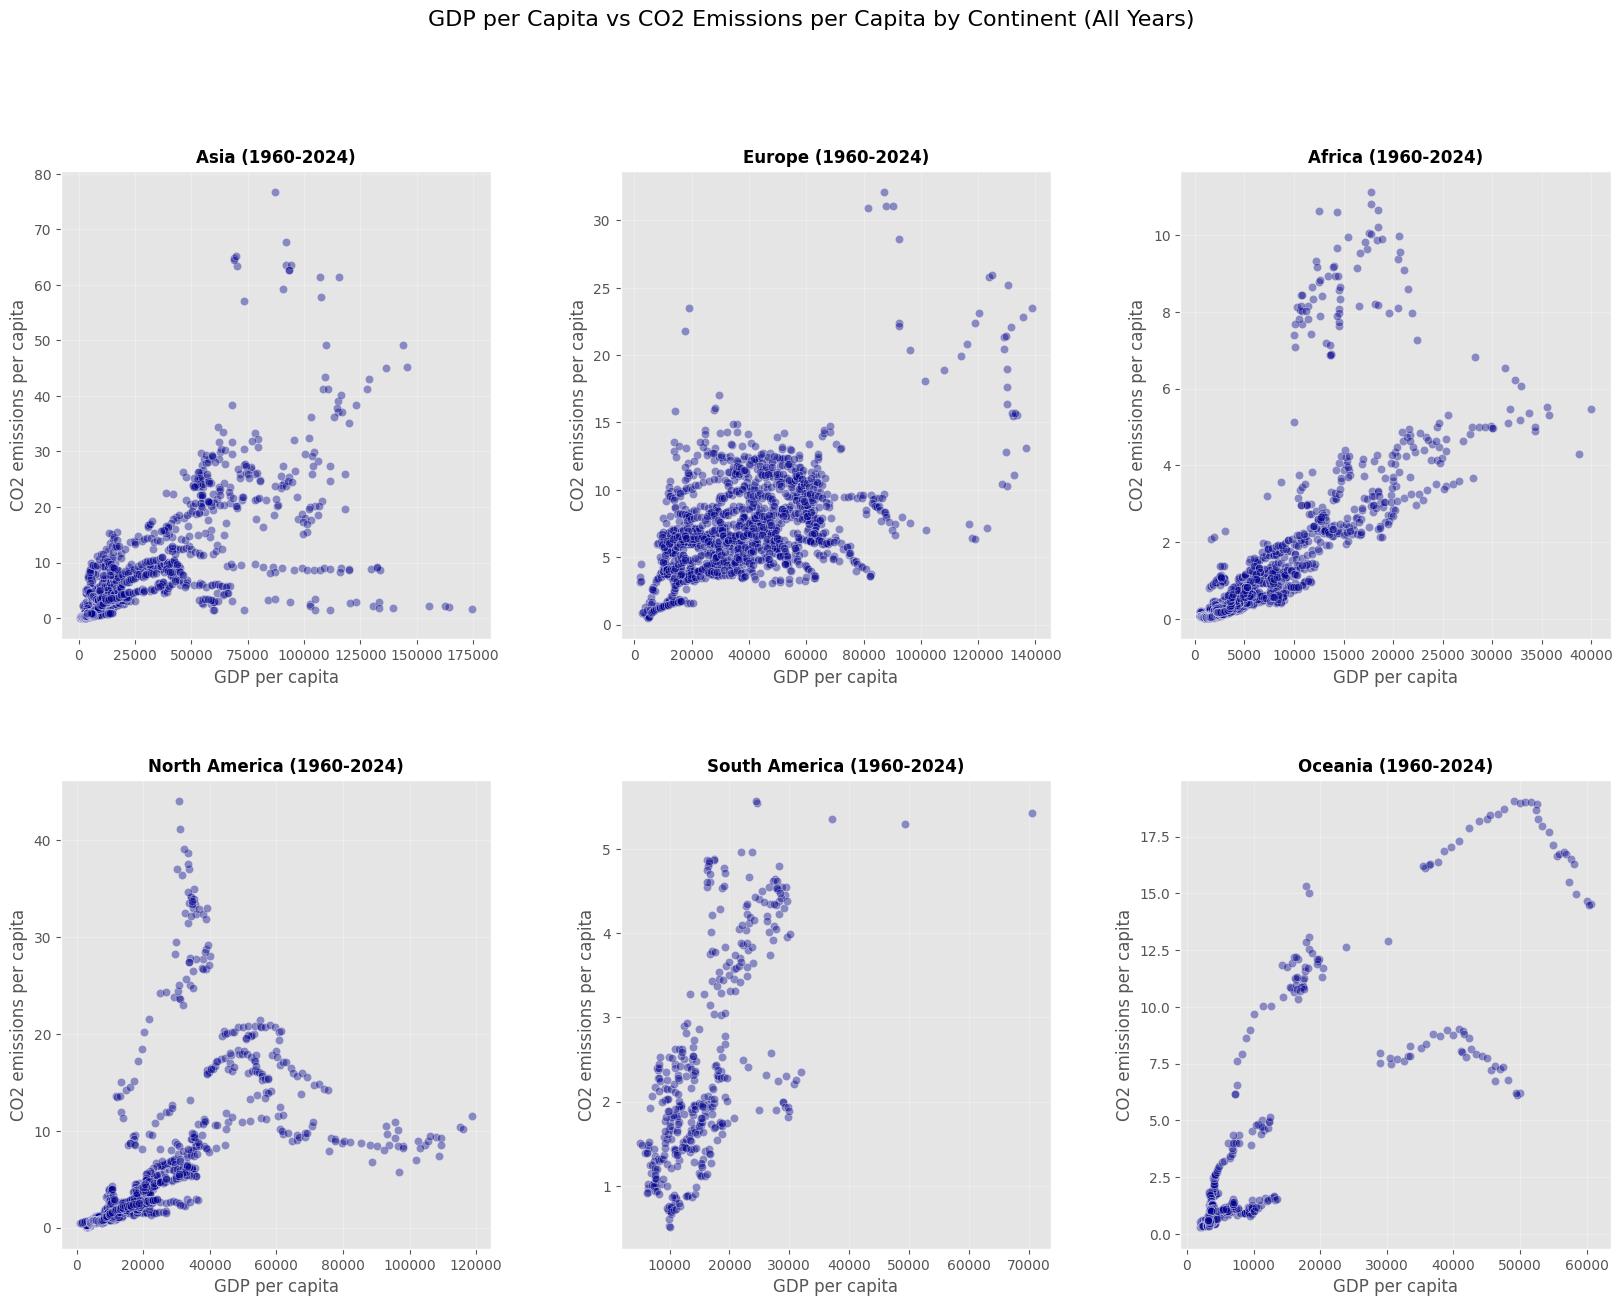

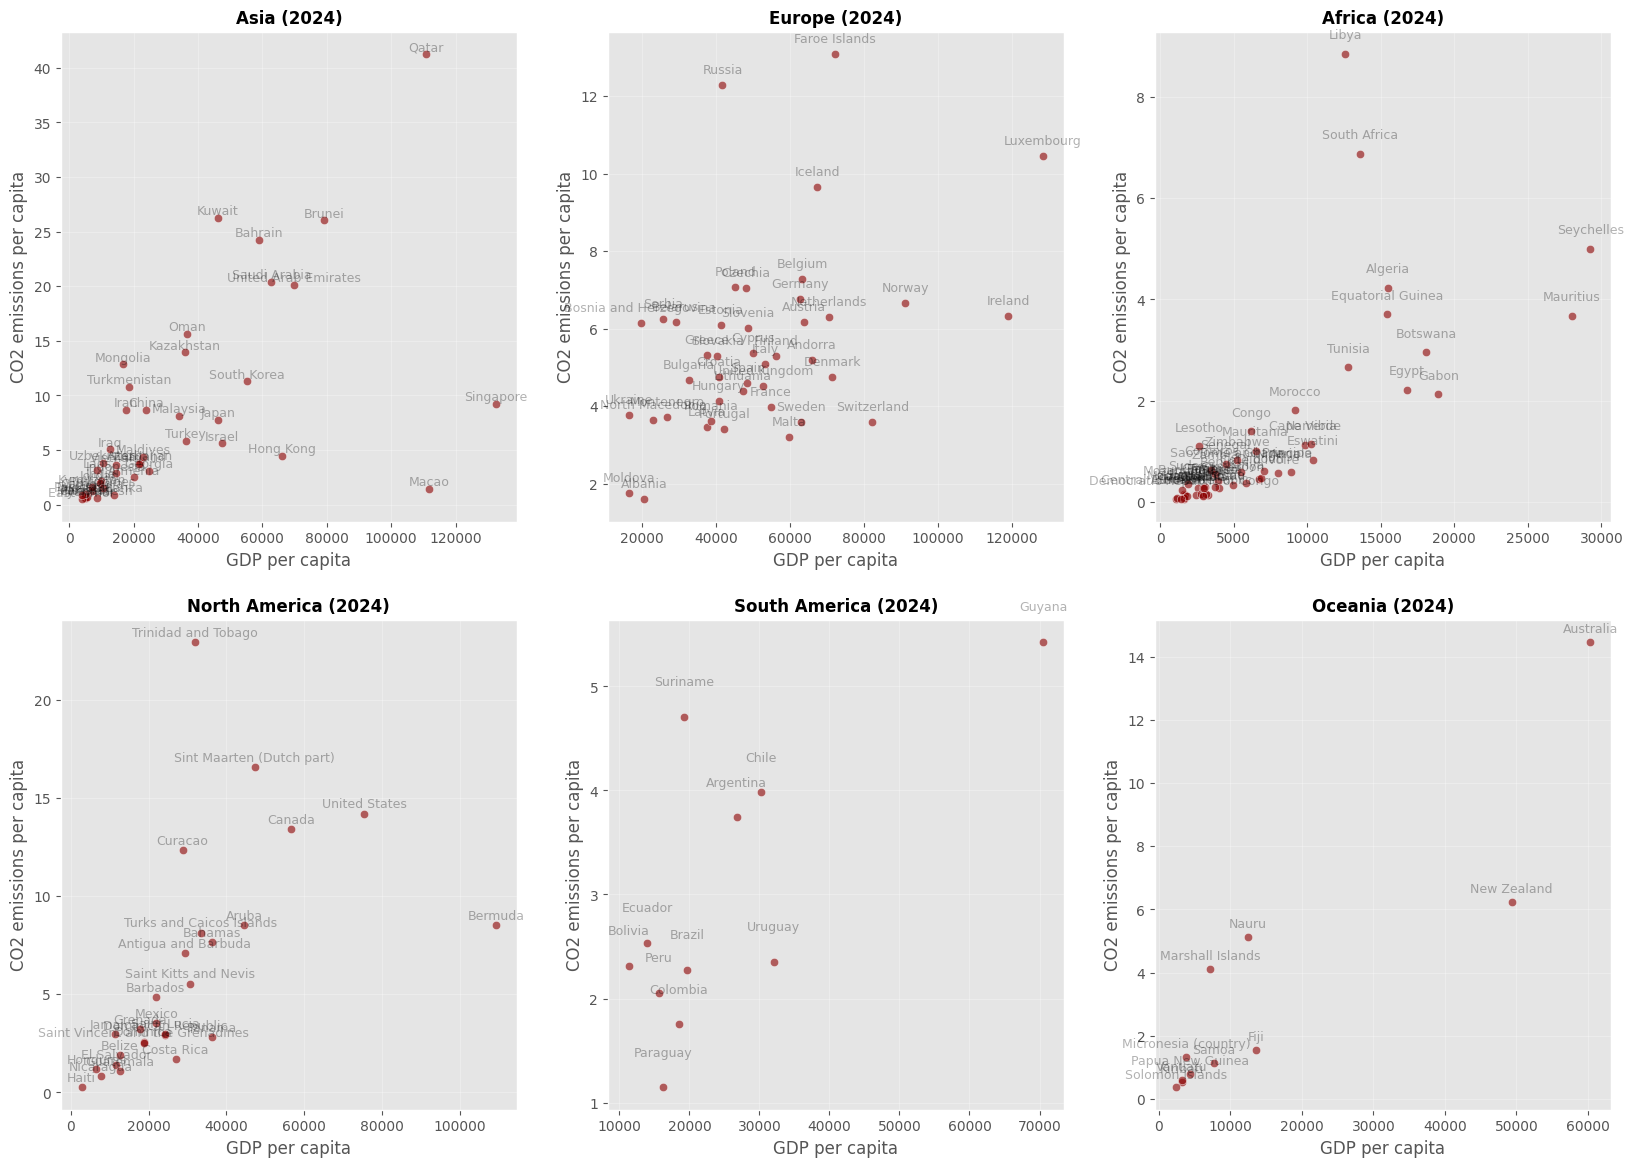

In [ ]:
continents = df['Continent'].unique()
continents = [c for c in continents if pd.notna(c)]  # Remove NaN values

# Filter out outliers
df_filtered = df[df['CO2 emissions per capita'] < 350].copy()

# Create two main figures
fig_all_years, axes_all_years = plt.subplots(2, 3, figsize=(20, 14))
fig_2024, axes_2024 = plt.subplots(2, 3, figsize=(20, 14))

axes_all_years = axes_all_years.flatten()
axes_2024 = axes_2024.flatten()

for idx, continent in enumerate(continents):
    # All years scatterplot
    df_continent = df_filtered[df_filtered['Continent'] == continent]
    
    min_year = df_continent['Year'].min()
    max_year = df_continent['Year'].max()
    
    sns.scatterplot(data=df_continent, x='GDP per capita', 
                    y='CO2 emissions per capita', alpha=0.4, color='darkblue', ax=axes_all_years[idx])
    axes_all_years[idx].set_title(f'{continent} ({min_year}-{max_year})', fontsize=12, fontweight='bold')
    axes_all_years[idx].set_xlabel('GDP per capita')
    axes_all_years[idx].set_ylabel('CO2 emissions per capita')
    axes_all_years[idx].grid(True, alpha=0.3)
    
    # 2024 scatterplot
    df_continent_2024 = df_filtered[(df_filtered['Year'] == 2024) & (df_filtered['Continent'] == continent)]
    
    sns.scatterplot(data=df_continent_2024, x='GDP per capita', 
                    y='CO2 emissions per capita', alpha=0.6, color='darkred', ax=axes_2024[idx])
    axes_2024[idx].set_title(f'{continent} (2024)', fontsize=12, fontweight='bold')
    axes_2024[idx].set_xlabel('GDP per capita')
    axes_2024[idx].set_ylabel('CO2 emissions per capita')
    axes_2024[idx].grid(True, alpha=0.3)
    for i in range(df_continent_2024.shape[0]):
        axes_2024[idx].text(x=df_continent_2024['GDP per capita'].iloc[i], 
                            y=df_continent_2024['CO2 emissions per capita'].iloc[i] + 0.3,
                            s=df_continent_2024['Country Name'].iloc[i], 
                            fontsize=9, 
                            alpha=0.3,
                            ha='center')

# Hide unused subplots if continents < 6
for idx in range(len(continents), len(axes_all_years)):
    axes_all_years[idx].set_visible(False)
    axes_2024[idx].set_visible(False)

fig_all_years.suptitle('GDP per Capita vs CO2 Emissions per Capita by Continent (All Years)', fontsize=16, y=0.995)
fig_all_years.subplots_adjust(hspace=0.3, wspace=0.3)
fig_all_years.savefig('../outputs/plots/scatterplots/scatterplot_pc_all_continents_all_years.png', 
                      dpi=300, bbox_inches='tight')
plt.show()

fig_2024.suptitle('GDP per Capita vs CO2 Emissions per Capita by Continent (2024)', fontsize=16, y=0.995)
fig_2024.subplots_adjust(hspace=0.3, wspace=0.3)
fig_2024.savefig('../outputs/plots/scatterplots/scatterplot_pc_all_continents_2024.png', 
                 dpi=300, bbox_inches='tight')
plt.show()

Total GDP vs Total CO2 emissions by Continent 

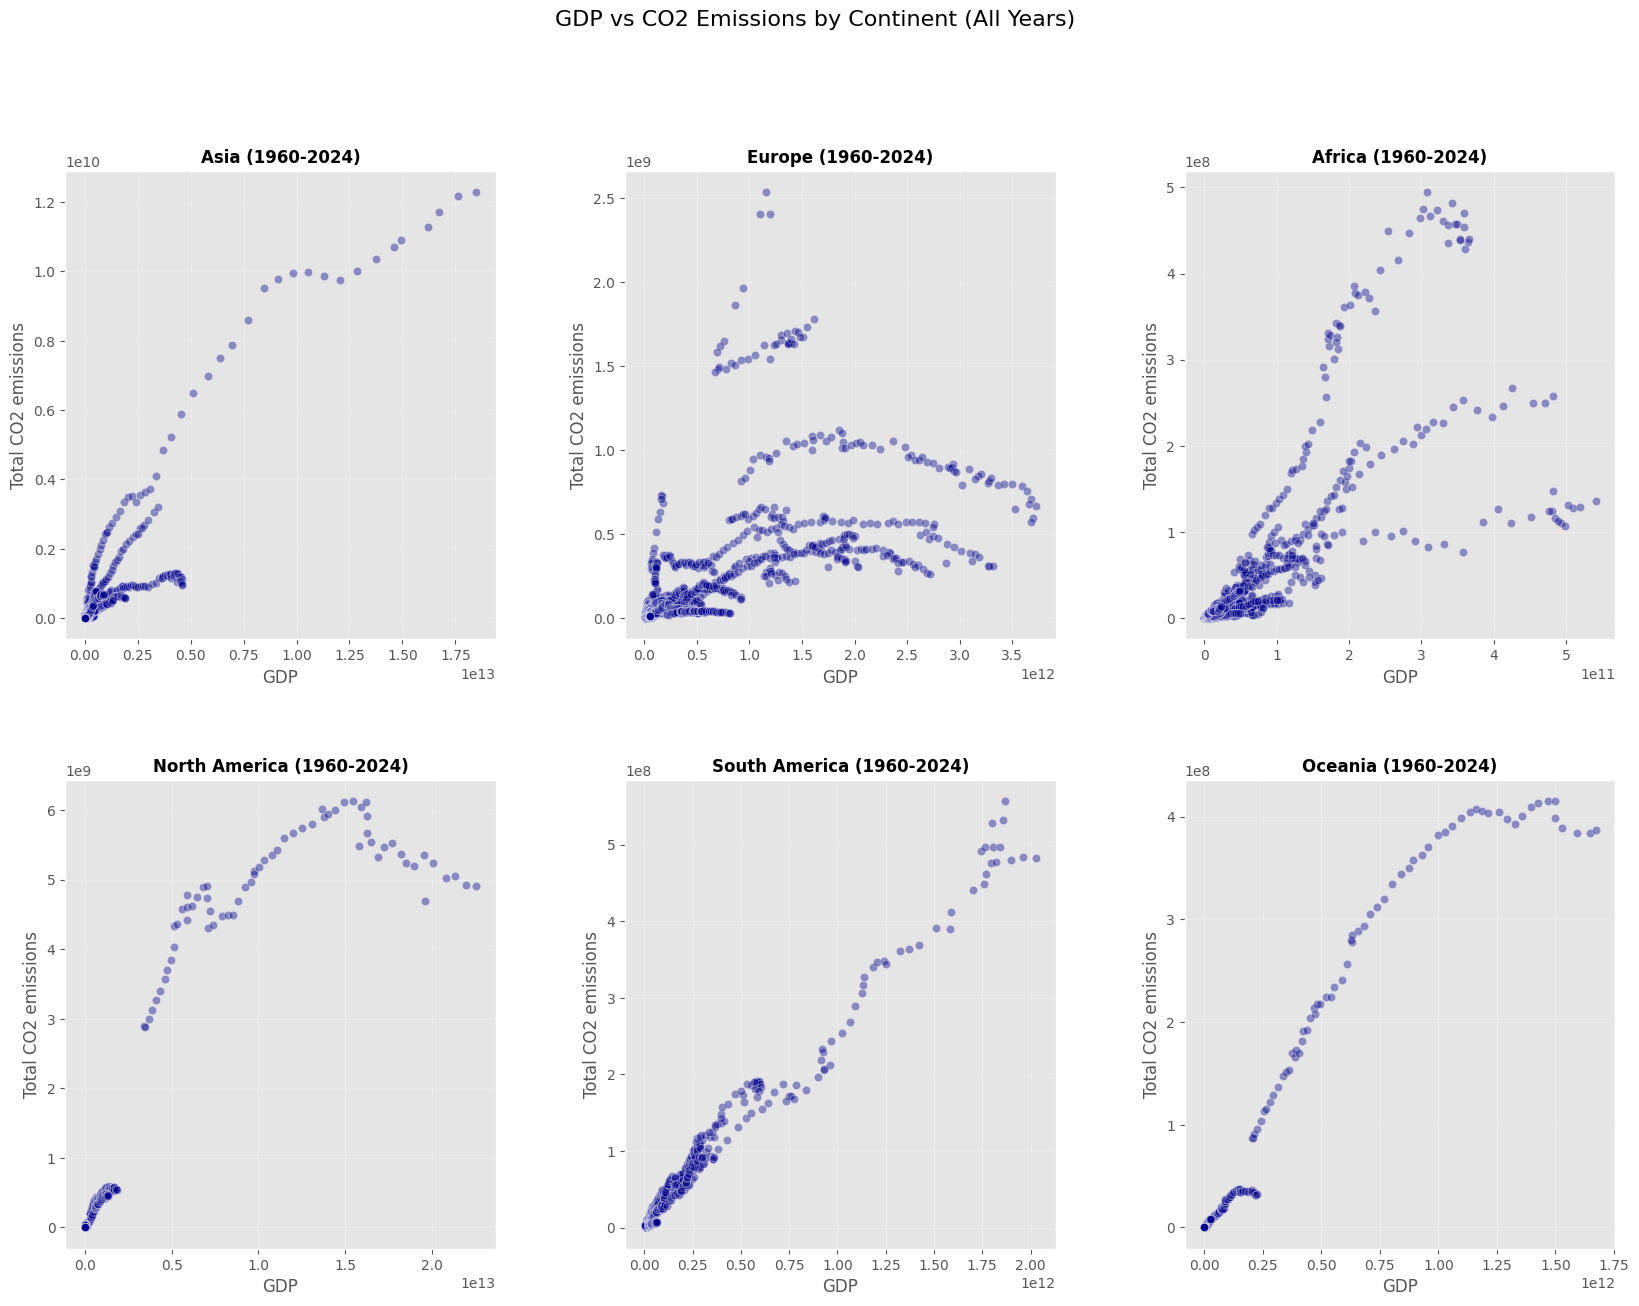

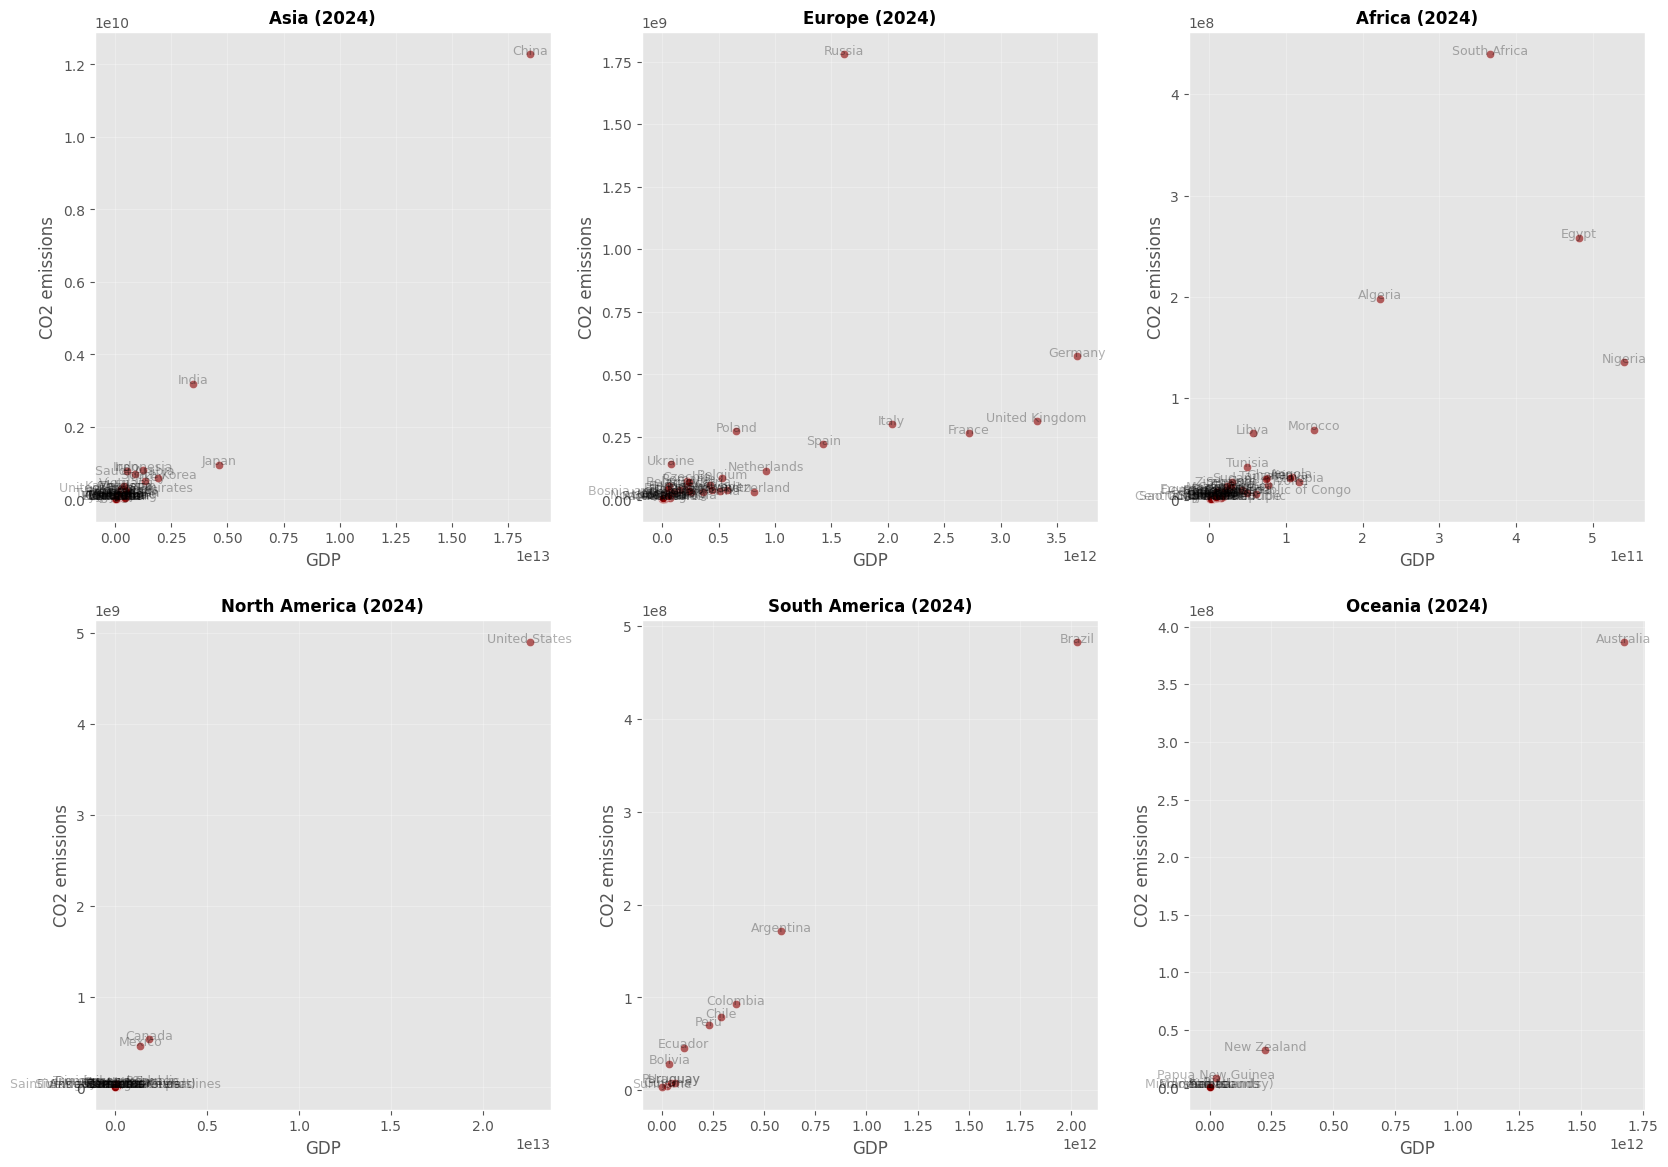

In [11]:
continents = df['Continent'].unique()
continents = [c for c in continents if pd.notna(c)]  # Remove NaN values

# Filter out outliers
df_filtered = df[df['CO2 emissions per capita'] < 350].copy()

# Create two main figures
fig_all_years, axes_all_years = plt.subplots(2, 3, figsize=(20, 14))
fig_2024, axes_2024 = plt.subplots(2, 3, figsize=(20, 14))

axes_all_years = axes_all_years.flatten()
axes_2024 = axes_2024.flatten()

for idx, continent in enumerate(continents):
    # All years scatterplot
    df_continent = df_filtered[df_filtered['Continent'] == continent]
    
    min_year = df_continent['Year'].min()
    max_year = df_continent['Year'].max()
    
    sns.scatterplot(data=df_continent, x='GDP', 
                    y='Total CO2 emissions', alpha=0.4, color='darkblue', ax=axes_all_years[idx])
    axes_all_years[idx].set_title(f'{continent} ({min_year}-{max_year})', fontsize=12, fontweight='bold')
    axes_all_years[idx].set_xlabel('GDP')
    axes_all_years[idx].set_ylabel('Total CO2 emissions')
    axes_all_years[idx].grid(True, alpha=0.3)
    
    # 2024 scatterplot
    df_continent_2024 = df_filtered[(df_filtered['Year'] == 2024) & (df_filtered['Continent'] == continent)]
    
    sns.scatterplot(data=df_continent_2024, x='GDP', 
                    y='Total CO2 emissions', alpha=0.6, color='darkred', ax=axes_2024[idx])
    axes_2024[idx].set_title(f'{continent} (2024)', fontsize=12, fontweight='bold')
    axes_2024[idx].set_xlabel('GDP')
    axes_2024[idx].set_ylabel('CO2 emissions')
    axes_2024[idx].grid(True, alpha=0.3)
    for i in range(df_continent_2024.shape[0]):
        axes_2024[idx].text(x=df_continent_2024['GDP'].iloc[i], 
                            y=df_continent_2024['Total CO2 emissions'].iloc[i] + 0.5,
                            s=df_continent_2024['Country Name'].iloc[i], 
                            fontsize=9, 
                            alpha=0.3,
                            ha='center')

# Hide unused subplots if continents < 6
for idx in range(len(continents), len(axes_all_years)):
    axes_all_years[idx].set_visible(False)
    axes_2024[idx].set_visible(False)

fig_all_years.suptitle('GDP vs CO2 Emissions by Continent (All Years)', fontsize=16, y=0.995)
fig_all_years.subplots_adjust(hspace=0.3, wspace=0.3)
fig_all_years.savefig('../outputs/plots/scatterplots/scatterplot_all_continents_all_years.png', 
                      dpi=300, bbox_inches='tight')
plt.show()

fig_2024.suptitle('GDP vs CO2 Emissions by Continent (2024)', fontsize=16, y=0.995)
fig_2024.subplots_adjust(hspace=0.3, wspace=0.3)
fig_2024.savefig('../outputs/plots/scatterplots/scatterplot_all_continents_2024.png', 
                 dpi=300, bbox_inches='tight')
plt.show()